In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal=sns.color_palette()

In [5]:
df = pd.read_csv('PJME_hourly.csv')

In [7]:
df = df.set_index('Datetime')

In [15]:
df.index = pd.to_datetime(df.index)

In [16]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<Axes: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

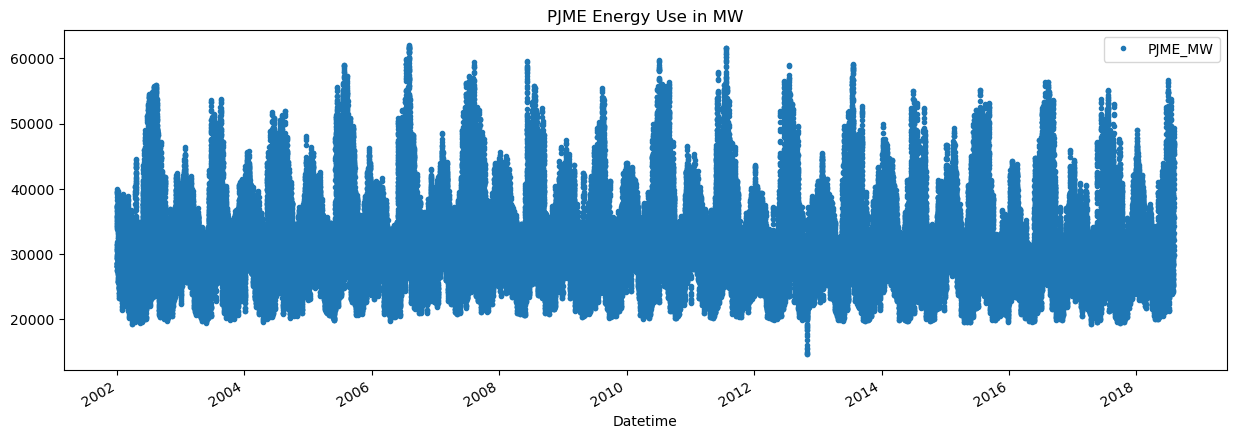

In [18]:
df.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJME Energy Use in MW')

## Train / Test Split

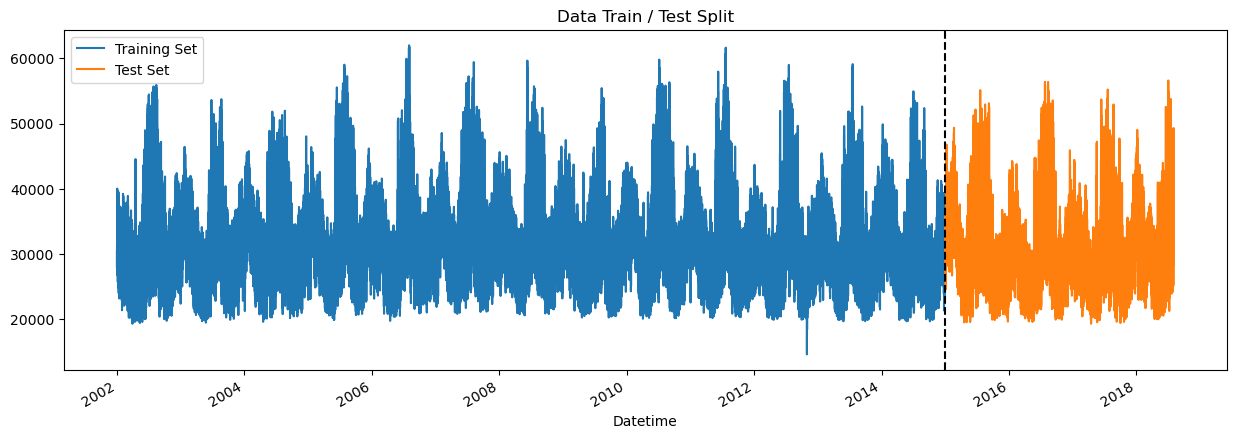

In [21]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title='Data Train / Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

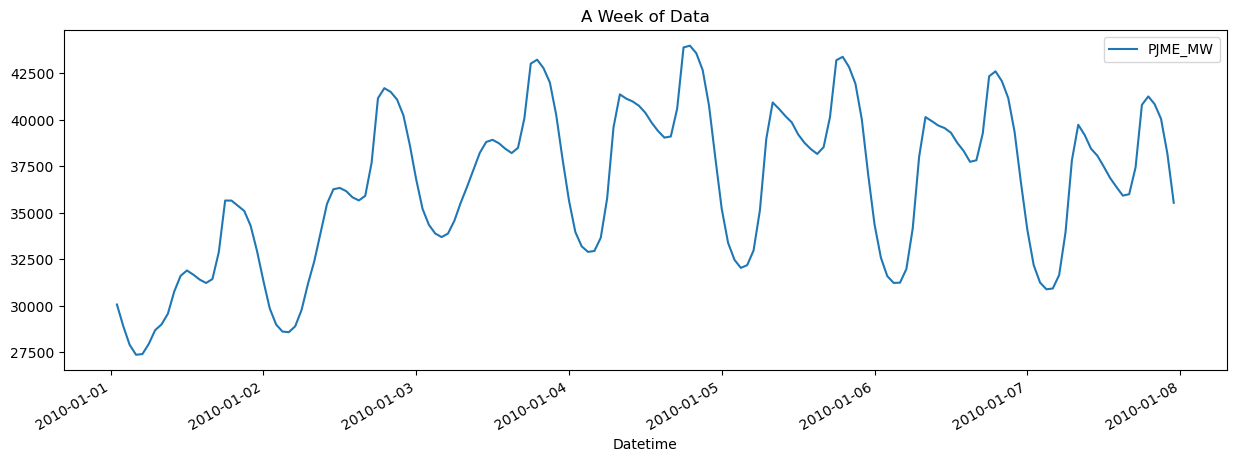

In [23]:
df.loc[(df.index > '2010-01-01') & (df.index < '2010-01-08')].plot(figsize=(15,5), title = 'A Week of Data')
plt.show()

## Feature Creation

In [32]:
def create_features(df):
    """
    Create Time Series features based on Time Series Index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [25]:
df = create_features(df)

In [26]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


## Visualize Feature / Target Relationship

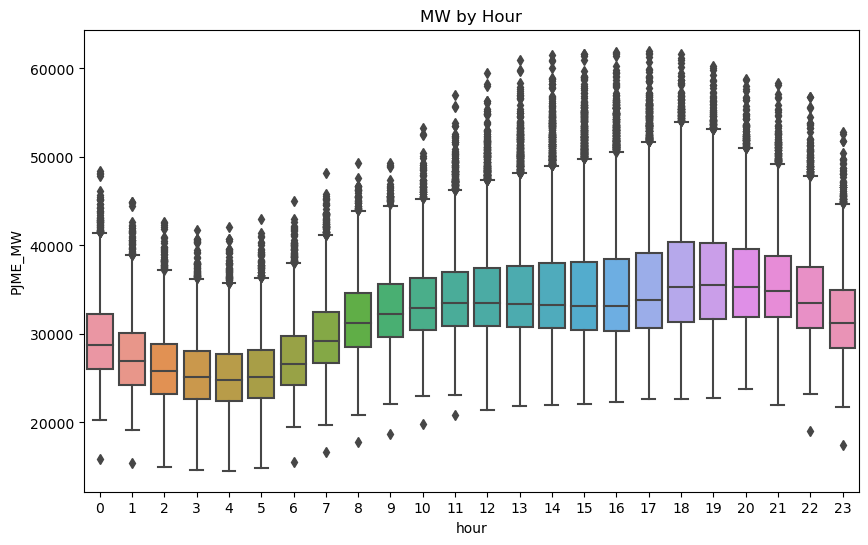

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

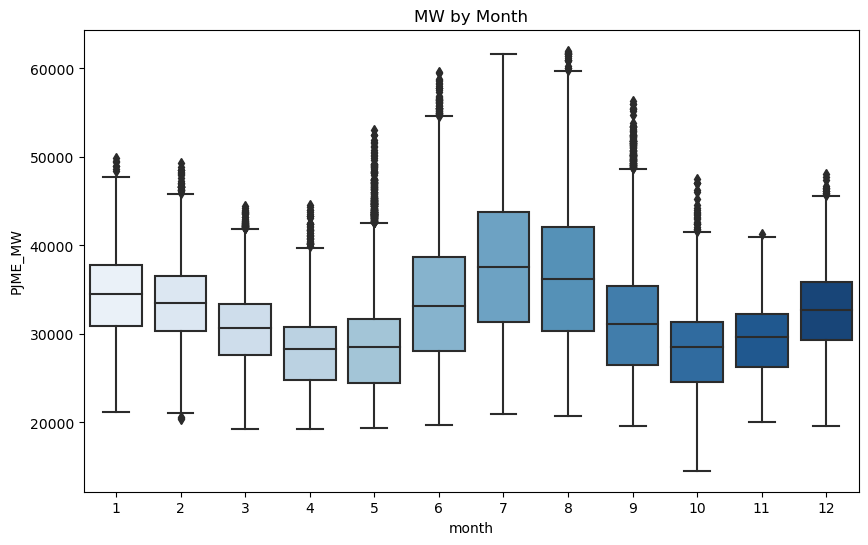

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

## Creating the Model

In [33]:
train = create_features(train)
test = create_features(test)

In [34]:
FEATURES = ['hour','dayofweek','quarter','month','year','dayofyear']
TARGET = 'PJME_MW'

In [35]:
X_train = train[FEATURES]
Y_train = train[TARGET]
X_test = test[FEATURES]
Y_test = test[TARGET]

In [37]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_test, Y_test)], verbose=100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[451]	validation_0-rmse:2771.05175	validation_1-rmse:3731.37067


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Feature Importance

In [40]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])

In [42]:
fi

,importance
hour,0.448804
dayofweek,0.158668
quarter,0.033319
month,0.228156
year,0.022634
dayofyear,0.108419


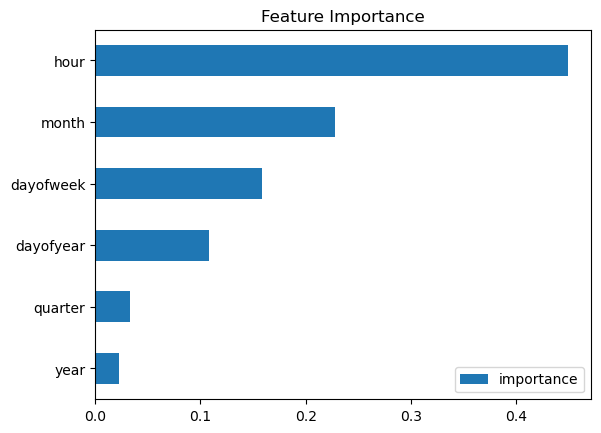

In [43]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast Test Set

In [44]:
test['prediction'] = reg.predict(X_test)

In [45]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

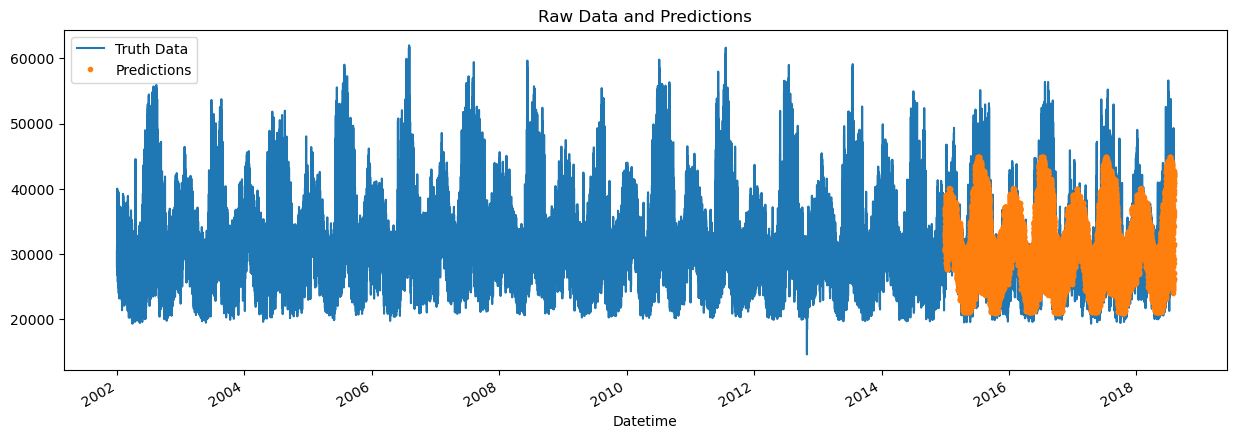

In [48]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data','Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

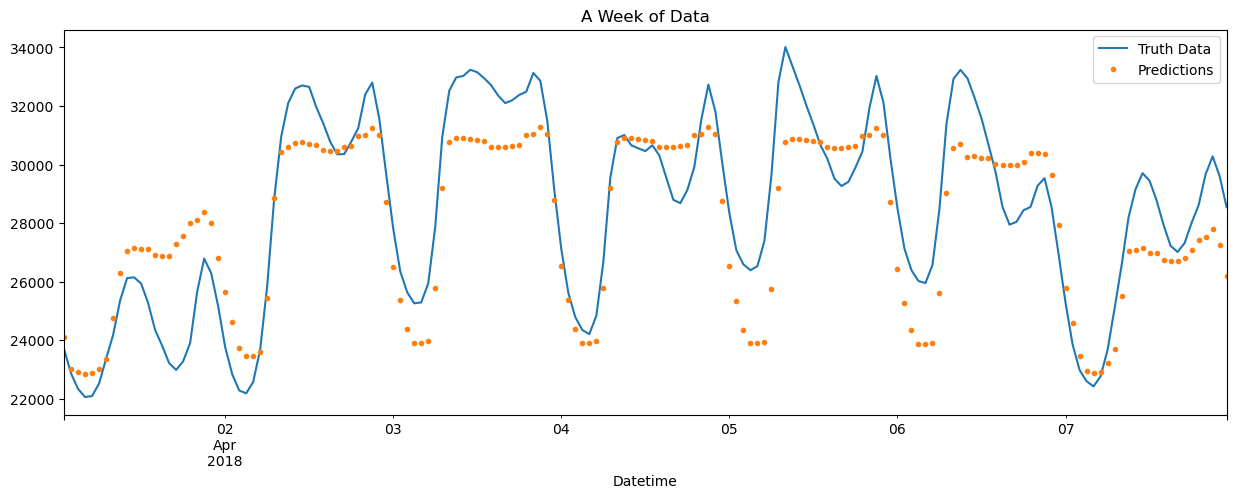

In [49]:
ax = df.loc[(df.index > '2018-04-01') & (df.index < '2018-04-08')]['PJME_MW'].plot(figsize=(15,5), title = 'A Week of Data')
df.loc[(df.index > '2018-04-01') & (df.index < '2018-04-08')]['prediction'].plot(style='.')
plt.legend(['Truth Data','Predictions'])
plt.show()

In [51]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test Set : {score:0.2f}')

RMSE Score on Test Set : 3715.93


## Calculating Error
◾️ Looking at the best and worst predicted days

In [53]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [54]:
test['date'] = test.index.date

In [60]:
#Top 5 Worst Predicted Days
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
Name: error, dtype: float64

In [61]:
#Top 5 Best Predicted Days
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2016-04-04    389.607829
2016-09-27    396.752116
2015-03-10    456.506510
2016-05-01    465.372640
2016-12-08    494.141764
Name: error, dtype: float64